# Выбор локации для скважины добывающей компании.

**Цель**: добывающей компании нужно решить, где бурить новую скважину.

**Исходные данные**: предоставлены пробы нефти в трёх регионах - в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. 

**Задачи**: построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, проанализировать возможную прибыль и риски (Bootstrap).

## Загрузка и подготовка данных

In [1]:
! pip install phik -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [2]:
# импортируем необходимые библиотеки:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error
# импортируем класс:
from sklearn.model_selection import RandomizedSearchCV
# загружаем нужную модель
from sklearn.linear_model import LinearRegression

from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [3]:
# данные первого региона:
region1 = pd.read_csv ('/datasets/geo_data_0.csv')
display(region1.head())
region1.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
# данные второго региона:
region2 = pd.read_csv ('/datasets/geo_data_1.csv')
display(region2.head())
region2.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
# данные третьего региона:
region3 = pd.read_csv ('/datasets/geo_data_2.csv')
display(region3.head())
region3.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
# проверим данные на наличие дубликатов:
print (f'Кол-во дубликатов в region1:', region1.duplicated().sum())
print (f'Кол-во дубликатов в region2:', region2.duplicated().sum())
print (f'Кол-во дубликатов в region3:', region3.duplicated().sum())

Кол-во дубликатов в region1: 0
Кол-во дубликатов в region2: 0
Кол-во дубликатов в region3: 0


Каждый из 3 датасетов содержит информацию о 100 000 скважинах, имеющих уникальный идентификатор, и их 3 признаках, характеризующих качество нефти в скважине, а также информацию об объёмах запасов нефти в скважине в тыс. баррелей. Пропуски и явные дубликаты в данных отсутствуют, типы данных имеют соответствующий содержимому формат. 

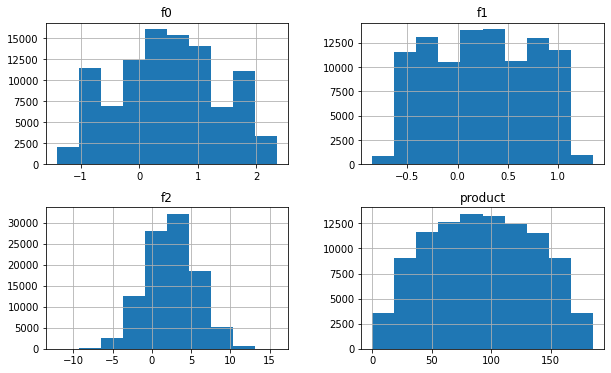

In [7]:
# посмотрим на распределение признаков в регионе 1:
region1.drop('id', axis=1).hist(bins=10, figsize=(10, 6));

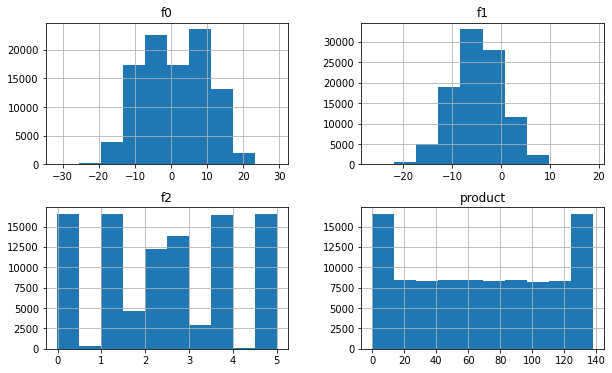

In [8]:
# посмотрим на распределение признаков в регионе 2:
region2.drop('id', axis=1).hist(bins=10, figsize=(10, 6));

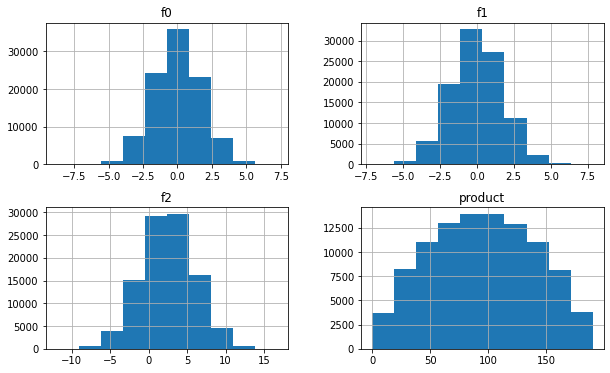

In [9]:
# посмотрим на распределение признаков в регионе 3:
region3.drop('id', axis=1).hist(bins=10, figsize=(10, 6));

Признаки месторождений 1 и 3 регионов распределены нормально в отличии от признаков месторождений второго региона, где признак f2, а также целевой признак имеют несколько пиков. Выбросы и аномальные значения в данных не наблюдаются.

Проведем корреляционный анализ признаков:

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


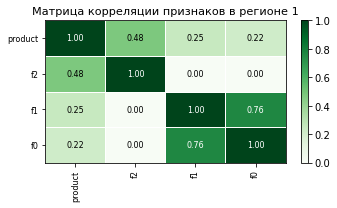

In [10]:
# посмотрим на распределение признаков в регионе 1:
phik_overview = phik_matrix(region1.drop('id', axis=1))
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции признаков в регионе 1',
    fontsize_factor=0.8,
    figsize=(5, 3)
);

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


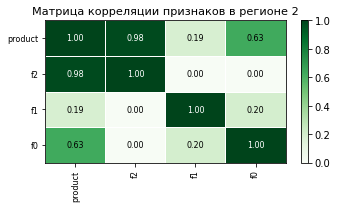

In [11]:
# посмотрим на распределение признаков в регионе 2:
phik_overview = phik_matrix(region2.drop('id', axis=1))
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции признаков в регионе 2',
    fontsize_factor=0.8,
    figsize=(5, 3)
);

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


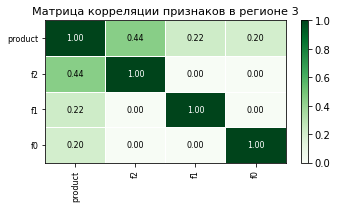

In [12]:
# посмотрим на распределение признаков в регионе 3:
phik_overview = phik_matrix(region3.drop('id', axis=1))
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции признаков в регионе 3',
    fontsize_factor=0.8,
    figsize=(5, 3)
);

Мультиколлинеарность между входными признаками не наблюдается. Наибольшее влияние на целевой признак оказывает признак f2, при это сильнее всего он оказывает влияние в регионе 2 (0,98 против 0,48 и 0,44 в регионах 1 и 2).

## Обучение и проверка модели

Разделим данные 3 регионов на обучающую и валидационную выборки в соотношении 75:25.

In [13]:
# сделаем это через функцию:
RANDOM_STATE = 42 # создание константы RANDOM_STATE

def prepare_data(name):
    # id превращаем в индексы строк, т.к. данный признак не понадобится в моделировании
    name = name.set_index('id')
    # выделим целевой и обучающие признаки:
    X = name.drop(columns='product')
    y = name['product']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

Обучим модель линейной регрессии и сделаем предсказания на валидационной выборке.

In [14]:
# инициализация модели:
model = LinearRegression()

In [15]:
regions = [region1, region2, region3]
num = 0
for reg in regions:
    num += 1
    X_train, X_test, y_train, y_test = prepare_data(reg)
    model = model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f'Cредний запас предсказанного сырья в регионе {num}: {preds.mean()}, среднее отклонение от истинного значения: {rmse}');

Cредний запас предсказанного сырья в регионе 1: 92.39879990657768, среднее отклонение от истинного значения: 37.75660035026169
Cредний запас предсказанного сырья в регионе 2: 68.71287803913762, среднее отклонение от истинного значения: 0.890280100102884
Cредний запас предсказанного сырья в регионе 3: 94.77102387765939, среднее отклонение от истинного значения: 40.145872311342174


Модель линейной регрессии лучше всего предсказывает объем сырья в регионе 2, где средний объем сырья = 68,7 +/- 0,9 тыс. баррелей. В регионе 1 и 2 средние объемы предсказанного сырья - 92 и 94 тыс. баррелей соответственно, но отклонение предсказания от истинных значений при этом 38 и 40 тыс. бареллей.

## Подготовка к расчёту прибыли

In [16]:
# обозначим ключевые значения для расчётов отдельными переменными:
BUDGET = 10_000_000
PROFIT = 450
POINTS = 500
BEST_POINTS = 200
LOSSES = 0.025

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

In [17]:
volume = BUDGET/(BEST_POINTS * PROFIT)
round(volume, 2)

111.11

Для безубыточной разработки необходимо добывать не менее 111,11 тыс. баррелей в каждой из скважин, это больше, чем расчитанный средний объем в каждом из трех регионов, при этом меньше всего подходящих скважин находятся во втором регионе. Что значит, что в каждом регионе нужно отобрать наиболее производительные скважины, исключив скважины с маленьким предсказанным объемом добычи, в целях минимизации риска убытков.

Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [18]:
def total_profit(data):
    data = data.sort_values(by='preds', ascending = False)
    best_data = data [:BEST_POINTS]
    profit_200 = (best_data ['product'].sum()) * PROFIT
    return profit_200 - BUDGET

In [19]:
num = 0
for reg in regions:
    num += 1
    X_train, X_test, y_train, y_test = prepare_data(reg)
    model = model.fit(X_train, y_train)
    X_test['preds'] = model.predict(X_test)
    X_test['product'] = y_test
    print (f'Общая прибыль от добычи в 200 лучших скважинах региона {num}: {round(total_profit(X_test), 2)} тыс.руб.')

Общая прибыль от добычи в 200 лучших скважинах региона 1: 3359141.11 тыс.руб.
Общая прибыль от добычи в 200 лучших скважинах региона 2: 2415086.7 тыс.руб.
Общая прибыль от добычи в 200 лучших скважинах региона 3: 2598571.76 тыс.руб.


На валидационных данных лучший показатель прибыльности 200 скважин продемонстрировал регион 1.

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли в каждом регионе.

In [20]:
state = np.random.RandomState(12345)
num = 0
for reg in regions:    
    num += 1
    X_train, X_test, y_train, y_test = prepare_data(reg)
    model = model.fit(X_train, y_train)
    X_test['preds'] = model.predict(X_test)
    X_test['product'] = y_test 
    values = []
    for i in range(1000):
        subsample = X_test.sample(frac=POINTS/X_test.shape[0], replace=True, random_state=state)
        values.append(total_profit(subsample))
    values = pd.Series(values)
    lower = values.quantile(0.025) #  95%-й доверительный интервал
    upper = values.quantile(0.975)
    mean = values.mean() # средняя прибыль
    print(f'Cредняя прибыль 200 лучших скважин регионе {num}: {round(mean, 2)} тыс. руб.')
    print(f'C вероятностью 95 % будет в среднем получена прибыль от {round(lower, 2)} до {round(upper, 2)} тыс. руб.')
    print(f'Вероятность убытков (в среднем = {round(values[values < 0].mean(), 2)} тыс. руб.) составляет', 
          f'{round((len(values[values < 0]) / len(values)) * 100, 2)} %.')
    print()

Cредняя прибыль 200 лучших скважин регионе 1: 406278.78 тыс. руб.
C вероятностью 95 % будет в среднем получена прибыль от -117742.14 до 911737.05 тыс. руб.
Вероятность убытков (в среднем = -123640.02 тыс. руб.) составляет 6.7 %.

Cредняя прибыль 200 лучших скважин регионе 2: 441504.28 тыс. руб.
C вероятностью 95 % будет в среднем получена прибыль от 35728.49 до 828006.64 тыс. руб.
Вероятность убытков (в среднем = -88483.8 тыс. руб.) составляет 1.6 %.

Cредняя прибыль 200 лучших скважин регионе 3: 385213.2 тыс. руб.
C вероятностью 95 % будет в среднем получена прибыль от -164785.17 до 888206.23 тыс. руб.
Вероятность убытков (в среднем = -126558.61 тыс. руб.) составляет 7.8 %.



**Вывод**: исходя из проведенного исследования наибольшую инвестиционную привлекательность имеет регион 2, т. к. прогнозируемая прибыль от разработки 200 лучших месторождений нефти в нем принесет в среднем прибыль = 441 504.28 тыс. руб. (наилучший показатель в трех регионах), при этом риск получения убытка находится в пределах допустимого значения (менее 2,5%) и убыток возможен в среднем около 88 483.8 тыс. руб. Регионы 1 и 3 не является привлекательным для инвестирования, т.к. риск возникновения убытков при инвестировании в них выше допустимого значения в 2,5 %.